In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from nltk.corpus import stopwords
import re

In [2]:
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='latin1', header=None)
df.columns = ['polarity', 'id', 'date', 'query', 'user', 'text']

In [3]:
df.head()

,polarity,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   polarity  1600000 non-null  int64 
 1   id        1600000 non-null  int64 
 2   date      1600000 non-null  object
 3   query     1600000 non-null  object
 4   user      1600000 non-null  object
 5   text      1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [5]:
tfidf = TfidfVectorizer(sublinear_tf=True, encoding='utf-8', decode_error='ignore', stop_words='english')
features = tfidf.fit_transform(df.text)

In [6]:
#splitting the dataset into testing and training
X_train, X_test, y_train, y_test = train_test_split(features, df['polarity'], test_size=0.2, random_state=7)

In [7]:
#applying the naive bayes
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train, y_train)

MultinomialNB()

In [8]:
#performance evaluation for the Naive Bayes
y_pred_nb = naive_bayes.predict(X_test)

print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Naive Bayes Precision:", precision_score(y_test, y_pred_nb, pos_label=4, average='binary'))
print("Naive Bayes Recall:", recall_score(y_test, y_pred_nb, pos_label=4, average='binary'))
print("Naive Bayes F1 Score:", f1_score(y_test, y_pred_nb, pos_label=4, average='binary'))

Naive Bayes Accuracy: 0.7615375
Naive Bayes Precision: 0.7773922790536303
Naive Bayes Recall: 0.7306877045993302
Naive Bayes F1 Score: 0.7533167817518815


In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

In [10]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 691051 unique tokens.


In [11]:
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (1600000, 250)


In [12]:
Y = pd.get_dummies(df['polarity']).values
print('Shape of label tensor:', Y.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

Shape of label tensor: (1600000, 2)
(1280000, 250) (1280000, 2)
(320000, 250) (320000, 2)


In [13]:
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(Y.shape[1], activation='softmax'))  # change here
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)

Epoch 1/5
18000/18000 [==============================] - 1081s 60ms/step - loss: 0.4128 - accuracy: 0.8107 - val_loss: 0.4026 - val_accuracy: 0.8170
Epoch 2/5
18000/18000 [==============================] - 1154s 64ms/step - loss: 0.3507 - accuracy: 0.8461 - val_loss: 0.3893 - val_accuracy: 0.8256
Epoch 3/5
18000/18000 [==============================] - 1178s 65ms/step - loss: 0.2966 - accuracy: 0.8747 - val_loss: 0.4238 - val_accuracy: 0.8181
Epoch 4/5
18000/18000 [==============================] - 1101s 61ms/step - loss: 0.2438 - accuracy: 0.9006 - val_loss: 0.4552 - val_accuracy: 0.8140
Epoch 5/5
18000/18000 [==============================] - 1155s 64ms/step - loss: 0.1999 - accuracy: 0.9209 - val_loss: 0.5143 - val_accuracy: 0.7994


In [14]:
# Evaluate the model on the test data
score, acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)

print("Test Score:", score)
print("Test Accuracy:", acc)

5000/5000 - 30s - loss: 0.5135 - accuracy: 0.7990 - 30s/epoch - 6ms/step
Test Score: 0.5134857892990112
Test Accuracy: 0.798981249332428


10000/10000 [==============================] - 35s 3ms/step


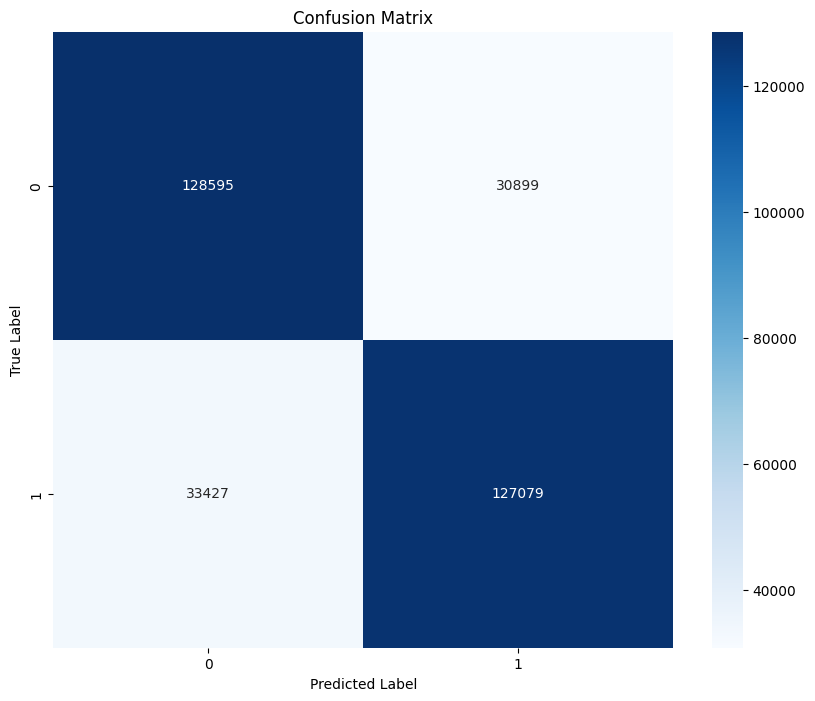

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.81      0.80    159494
           1       0.80      0.79      0.80    160506

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000



In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict the values from the test data
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1) 
Y_true = np.argmax(Y_test, axis=1) 

# Create the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

# Visualize the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

print('Classification Report')
print(classification_report(Y_true, Y_pred_classes))


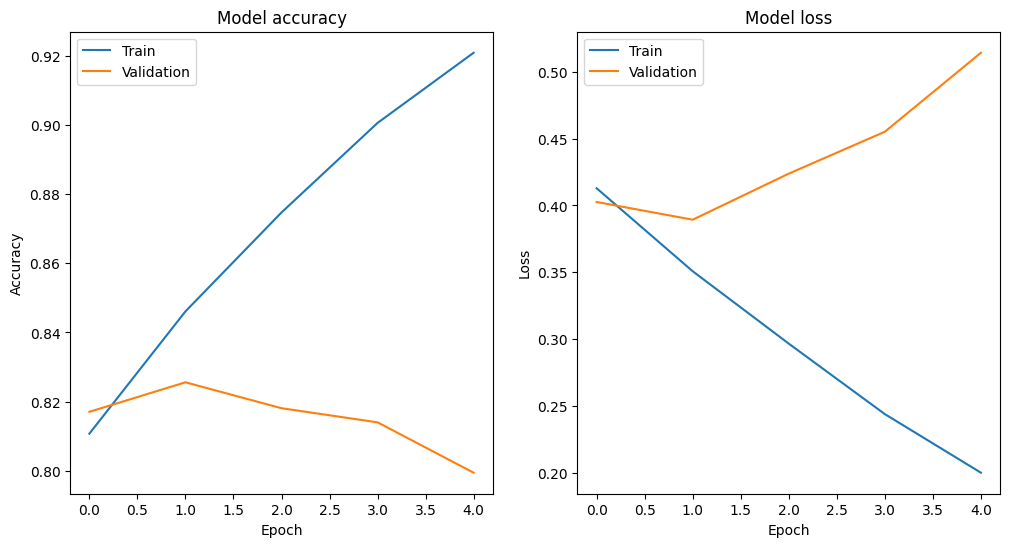

In [18]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()
